In [1]:
import transformers

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
model = transformers.AutoModel.from_pretrained('bert-base-uncased').to(device)

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
import datasets

In [5]:
d = datasets.load_dataset('glue', 'qqp')['validation'].shuffle(seed=42)

Reusing dataset glue (/home/jxm3/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/jxm3/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-e411a4f55239beea.arrow


In [6]:
len(d)

40430

In [7]:
d[0]

{'question1': 'How do I get rid of anxiety and depression?',
 'question2': 'How do I get rid of anxiety, loneliness and depression?',
 'label': 0,
 'idx': 11092}

In [10]:
from typing import List, Tuple

import tqdm
import torch

batch_size = 256
max_num_samples = 25_000

def get_bert_similarities(word_pairs: List[Tuple[str]]) -> torch.Tensor:
    word1 = [p[0] for p in word_pairs]
    word2 = [p[1] for p in word_pairs]
    
    word1_tokenized = tokenizer(word1, padding=True, truncation=True, return_tensors='pt')
    word1_tokenized = {k: v.to(device) for k,v in word1_tokenized.items()}
    
    word2_tokenized = tokenizer(word2, padding=True, truncation=True, return_tensors='pt')
    word2_tokenized = {k: v.to(device) for k,v in word2_tokenized.items()}
    
    
    with torch.no_grad():
        word1_reps = model(**word1_tokenized).last_hidden_state[:, 0, :]
        word2_reps = model(**word2_tokenized).last_hidden_state[:, 0, :]
    
    return torch.nn.CosineSimilarity(dim=1)(word1_reps, word2_reps)

question_pairs_with_sim = []
for i in tqdm.trange(0, min(max_num_samples, len(d)), batch_size, desc='processing synonyms'):
    question_pairs = [
        (d[j]['question1'], d[j]['question2'], d[j]['label']) for j in range(i, i+batch_size)
    ]
    sims = get_bert_similarities(question_pairs)
    for question_pair, sim in zip(question_pairs, sims):
        question_pairs_with_sim.append(
            # q1, q2, label, similarity
            (question_pair[0], question_pair[1], question_pair[2], sim.item())
        )


processing synonyms: 100%|██████████| 98/98 [00:53<00:00,  1.84it/s]


In [29]:
import pandas as pd

df = pd.DataFrame(question_pairs_with_sim, columns=['question1', 'question2', 'label', 'sim'])
df['label_str'] = df['label'].map(lambda x: 'paraphrase' if x == 1 else 'non-paraphrase')
df.head()

,question1,question2,label,sim,label_str
0,How do I get rid of anxiety and depression?,"How do I get rid of anxiety, loneliness and depression?",0,0.992775,non-paraphrase
1,How do I go about creating a device and an app that streams live video over wifi to an iPhone?,Is there a child like trait always alive somewhere inside?,0,0.863014,non-paraphrase
2,How can I begin a successful project?,How do I start a successful project?,1,0.976194,paraphrase
3,How can we leave MNC jobs to work for more meaningful NGOs and yet earn similarly?,First copy of Adidas Nike in Banglore?,0,0.746219,non-paraphrase
4,"What is the difference between a momo, a dimsum, a bao, a dumpling and a wonton?","What is the difference between dimsums, momos, siumai, wontons and dumplings?",0,0.981557,non-paraphrase


In [30]:
df['label_str'].value_counts()

non-paraphrase    15811
paraphrase         9277
Name: label_str, dtype: int64

/home/jxm3/.conda/envs/torch/lib/python3.9/site-packages/seaborn/distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


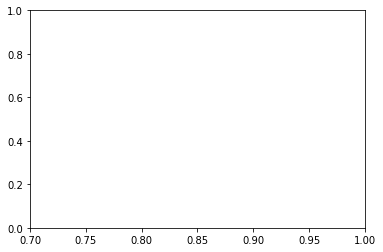

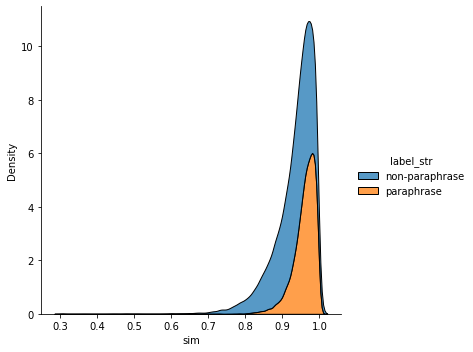

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
sns.kdeplot(data=df, x="sim", hue="label_str", kind="kde", multiple='stack', ax=ax) # multiple="layer")#
ax.set_xlim(0.7,1.0)
plt.show()

 ### What are the most similar and dissimilar paraphrases?

In [26]:
pd.set_option('display.max_colwidth', None)
df[df['label_str'] == 'paraphrase'].sort_values(by='sim', ascending=False).head(n=30)

,question1,question2,label,sim,label_str
5623,I ’m unable to continue LIC’s Jeevan Anand (Plan 149) & Jeevan Saral (Plan 165). What should I do ?,I ’m unable to continue LIC’s Jeevan Anand (Plan 149) & Jeevan Saral (Plan 165). What should I do?,1,1.000000,paraphrase
20039,What were the highlights of PM Modi's speech on New Year's Eve 2017 and what are your views about it?,What were the highlights of PM Modi's speech on New Year's Eve 2017 and what are your views about it ?,1,1.000000,paraphrase
22796,What's your favorite Chinese food ?,What's your favorite Chinese food?,1,1.000000,paraphrase
4357,What are the best places to visit in South India?,What are the best places to visit in South India ?,1,1.000000,paraphrase
19181,Why is Area 51 restricted ?,Why is Area 51 restricted?,1,1.000000,paraphrase
17143,"What are all the games I can play with Intel HD 5500, 16GB of RAM and an Intel i5 processor?","What are all the games I can play with Intel HD 5500, 8GB of RAM and an Intel i5 processor?",1,0.999957,paraphrase
12037,What is the difference between USB 3.0 and USB 2.0?,What is the difference between USB 2.0 and USB 3.0?,1,0.999747,paraphrase
10293,How do I get a iPhone for free?,How do I get an iPhone for free?,1,0.999511,paraphrase
10354,What is the difference between a company and a firm?,What is the difference between a firm and a company?,1,0.999503,paraphrase
20831,What is the difference between a beta particle and an electron?,What is the difference between an electron and a beta particle?,1,0.999406,paraphrase


In [27]:
df[df['label_str'] == 'paraphrase'].sort_values(by='sim', ascending=True).head(n=30)

,question1,question2,label,sim,label_str
18188,Why is Jake Williams so famous?,"""How/when did Jake Williams get """"famous"""" on Quora?""",1,0.305235,paraphrase
686,What programming language(s) are used to create Game Dev Tycoon? What engine do the developers use?,"""Indie Game: What engine is used for the game """"Game Dev Tycoon""""?""",1,0.600436,paraphrase
25056,What is some information about Pushpak Vimana found in Afghanistan?,"Recently I have read in newspaper about ancient vimana found in afghanistan? But it didn't given good depth information, if one can give please I have so much interested",1,0.694958,paraphrase
1745,What are the chances that the Modi govt. would abolish reservation based on caste?,"""Would Modi """"dare"""" to abolish the reservation?""",1,0.700404,paraphrase
5372,What is the best way to prepare for the theoretical part of the CA Final Exam?,How one should know that he/she completely prepare for CA final exam?,1,0.701999,paraphrase
13758,How one should know that he/she completely prepare for CA final exam?,What is the best way to prepare for CA final group1 papers?,1,0.713247,paraphrase
19368,What are the issues associated with creating new provinces in Pakistan?,Write short notes on issue of new provinces in pakistan?,1,0.715966,paraphrase
4481,Was the Egyptian god Horus really born on December 25?,"""Mythology: Was Egyptian God Horus born on 25th of December? What about other """"Gods"""" compared with Jesus in Zeitgeist movie?""",1,0.725272,paraphrase
1709,"What is actual meaning of life? Indeen, it depend on perception of people or other thing?",What is the meaning of my life?,1,0.728084,paraphrase
9965,"""At which date """"ae dil hai mushkil"""" movie trailer will release?""",When is the Ae Dil Hai Mushkil Trailer releasing?,1,0.732274,paraphrase


### What are the most similar and dissimilar non-paraphrases?

In [32]:
df[df['label_str'] == 'non-paraphrase'].sort_values(by='sim', ascending=False).head(n=30)

,question1,question2,label,sim,label_str
21294,I got 120 marks out of 250 in WBJEE Medical 2016. I am a SC Candidate. What will be my probable rank?,I got 130 marks out of 250 in WBJEE Medical 2016. I am a SC Candidate. What will be my probable rank?,0,0.999867,non-paraphrase
5016,What is it like to go through Course 15 at MIT?,What is it like to go through Course 12 at MIT?,0,0.999696,non-paraphrase
8979,What is it like to go through Course 14 at MIT?,What is it like to go through Course 16 at MIT?,0,0.999680,non-paraphrase
2573,How should Californians vote on 2016's Proposition 62?,How should Californians vote on 2016's Proposition 67?,0,0.999589,non-paraphrase
16105,How competitive is the hiring process at S & T Bank?,How competitive is the hiring process at M&T Bank?,0,0.999572,non-paraphrase
18821,"What are the best and worst things about public transit in Bilaspur, Chhattisgarh, India? How could it be improved?","What are the best and worst things about public transit in Raipur, Chhattisgarh, India? How could it be improved?",0,0.999540,non-paraphrase
23929,What is a six-pointed star symbolic of?,What is a seven-pointed star symbolic of?,0,0.999525,non-paraphrase
14599,What are the dangers of babies born 6 weeks early?,What are the dangers of babies born 5 weeks early?,0,0.999524,non-paraphrase
15331,What is your review of Game of Thrones Season 3?,What is your review of Game of Thrones Season 5?,0,0.999518,non-paraphrase
7489,How would the movie be if Karan Dharma Kama Johar had directed and produced the Hindi version of the movie Terminator 2?,How would the movie be if Karan Dharma Kama Johar had directed and produced the Hindi version of the movie Terminator 3?,0,0.999494,non-paraphrase


In [33]:
df[df['label_str'] == 'non-paraphrase'].sort_values(by='sim', ascending=True).head(n=30)

,question1,question2,label,sim,label_str
4380,Where can I watch Boruto (Naruto the movie) with Japanese audio and not Korean or English dubs?,"""Will Naruto die in """"Naruto: Boruto The Movie""""?""",0,0.364567,non-paraphrase
8478,What are the differences between love and not-love?,"""Love: What is the difference between """"I love you"""" and """"I have love for you""""?""",0,0.438798,non-paraphrase
24100,What is meant by digital transactions in India?,"""Can anybody write the lyrics and translate the song """"Lekha"""" from the Kuchipudi Dance Drama """"Bhama Kalapam""""?""",0,0.444200,non-paraphrase
22844,Is Slim Shady dead?,"""Is the rapper Eminem's fame decreasing due to his new, fast rapping style like in his latest album, """"Shady XV""""?""",0,0.455291,non-paraphrase
11292,"""What does the song """"Hey Soul Sister"""" from Train mean?""",What is the meaning of Naked Soul? What does it mean to be a Naked Soul?,0,0.475642,non-paraphrase
19960,Do anti China Western critics generally treat Apple daily in HK as a good example of highlighting the concept of Free media - editorial independence,"If a good is manufactured outside of the US by a US company and is then sold in the US does that mean it is exported from the country of manufacture and imported into the US? So, for example if Apple manufactures their iPhones in China and then brings them back to the US does that count as an exported good from China on China's balance sheets and an imported good on the US's balance sheets?",0,0.475888,non-paraphrase
5469,"How much money did Psy make from the Gangnam Style YouTube video, given that it is the most viewed video on YouTube?","""How much did it cost YouTube to stream """"Gangnam Style""""?""",0,0.476386,non-paraphrase
21790,%3c%2fscript%3e%3cscript%3ealert(1) %3c%2fscript%3 %3c%2fscript%3e%3cscript%3ealert(1) %3c%2fscript%3 %3c%2fscript%3e%3cscript%3ealert(1) %3c%2fscript%3?,What is the mechanism of fast charging in the new smartphone batteries?,0,0.482052,non-paraphrase
14914,"""What does the song """"I'm Not Made Of Steel"""" by Michael Bolton mean?""",What is the meaning of the song Castles Made of Sand?,0,0.490729,non-paraphrase
9237,"I'm 18 and my body doesn't consume alof of fat, I eat alot of fatty things but I can't get a alot fat, why?",What is the best type of Steering mechanism to use for a fuel efficient Prototype Car?,0,0.501939,non-paraphrase


### What's the accuracy of this zero-shot classifier?

In [38]:
def acc_for_sim(sim: float):
    num_nonp_correct = ((df['sim'] < sim) & (df['label'] == 0)).sum()
    num_p_correct = ((df['sim'] > sim) & (df['label'] == 1)).sum()
    return (num_p_correct + num_nonp_correct) / len(df)

In [46]:
import numpy as np

accs = []
for sim in tqdm.tqdm(np.arange(0,1.0,0.001), desc='computing accuracies'):
    accs.append((sim, acc_for_sim(sim)))

acc_df = pd.DataFrame(accs, columns=['sim', 'accuracy'])
acc_df.head()

computing accuracies: 100%|██████████| 1000/1000 [00:00<00:00, 1526.14it/s]


,sim,accuracy
0,0.000,0.369778
1,0.001,0.369778
2,0.002,0.369778
3,0.003,0.369778
4,0.004,0.369778


<AxesSubplot:xlabel='sim'>

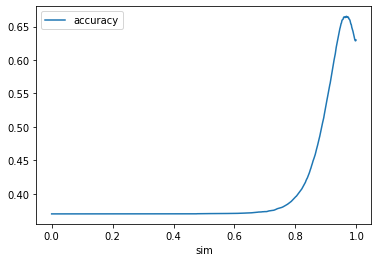

In [47]:
acc_df.plot(x='sim', y='accuracy')

In [50]:
acc_df.sort_values(by='accuracy', ascending=False)

,sim,accuracy
967,0.967,0.665497
971,0.971,0.664939
968,0.968,0.664820
960,0.960,0.664581
970,0.970,0.664501
...,...,...
340,0.340,0.369739
339,0.339,0.369739
338,0.338,0.369739
337,0.337,0.369739


In [52]:
df['label'].value_counts()

0    15811
1     9277
Name: label, dtype: int64

In [53]:
15811/(15811+9277)

0.6302216198979592